# Clustering in UMAP space

This script generates and evaluates clustering on a given UMAP representation.

The project directory should have at least the following structure and files:

    ├── data
    │   ├── df.pkl         <- pickled pandas dataframe with metadata and UMAP coordinates 
    ├── spec_params.py     <- python file containing the spectrogram parameters used (generated in 
                              01_generate_spectrograms.ipynb)

The following columns must exist (somewhere) in the pickled dataframe df.pkl:

    | filename   | spectrograms    |  samplerate_hz |    label
    --------------------------------------------------------------------
    | call_1.wav |  2D np.array    |      8000      |    A 
    | call_2.wav |  ...            |      48000     |    B 
    | ...        |  ...            |      ....      |    unknown

In [5]:
import os
import pandas as pd
import numpy as np
import json
from pathlib import Path
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import hdbscan
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score
import scipy
from plot_functions import umap_3Dplot, plotly_viz

%matplotlib inline

In [ ]:
# https://stackoverflow.com/questions/49586742/rand-index-function-clustering-performance-evaluation

def rand_index_score(clusters, classes):
    tp_plus_fp = scipy.special.comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = scipy.special.comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(scipy.special.comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum() for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = scipy.special.comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)
    
def calc_rand(pred, true):
    classnames, pred = np.unique(pred, return_inverse=True)
    classnames, true = np.unique(true, return_inverse=True)
    return rand_index_score(pred, true)

distinct_colors_22 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
                      '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
                      '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
                      '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
                      '#ffffff', '#000000']

In [ ]:
P_DIR = os.getcwd() # --> project directory default: your current working directory

# Load dataframe
df = pd.read_pickle(os.path.join(os.path.sep, P_DIR, 'data', 'df_umap.pkl'))

LABEL_COL = 'label'                                  # Column name of label variable
UMAP_COLS = [x for x in df.columns if 'UMAP' in x]   # detects UMAP columns

labels = df[LABEL_COL]
embedding = np.asarray(df[UMAP_COLS])

print("Found ", len(UMAP_COLS), "UMAP columns. Label in column : ", LABEL_COL)

# Clustering

The aim is to cluster the calls into distinct categories based on the UMAP values.
I try different clustering methods and compare their performance using several evaluation metrics.

In [12]:
HDBSCAN = hdbscan.HDBSCAN(min_cluster_size=int(0.01*embedding.shape[0]),
                          cluster_selection_method = 'leaf').fit(embedding)
hdb_labels = HDBSCAN.labels_

df['HDBSCAN'] = hdb_labels #  add to dataframe

In [ ]:
# also create HDBSCAN without noise
hdb_labels_no_noise = hdb_labels.copy()

assigned = np.full((len(hdb_labels_no_noise),), False)
assigned[np.where(hdb_labels_no_noise!=-1)[0]] = True
hdb_labels_no_noise = hdb_labels_no_noise[assigned] 
df_hdb = df.loc[assigned]
embedding_hdb = embedding[assigned,:]

## Cluster evaluation based on RI, ARI, SIL

In [15]:
# evaluate clustering 

print("************************")
print("HDBSCAN:")
print("************************")
cluster_labels = hdb_labels
true_labels = df[LABEL_COL]
embedding_data = embedding


print("RI: ", calc_rand(cluster_labels, true_labels))
print("ARI: ", adjusted_rand_score(cluster_labels, true_labels))
print("SIL: ", silhouette_score(embedding_data, cluster_labels))
print("N_clust: ", len(list(set(cluster_labels))))

print(" ")

print("************************")
print("HDBSCAN-no-noise:")
print("************************")
cluster_labels = hdb_labels_no_noise
true_labels = df_hdb[LABEL_COL]
embedding_data = embedding_hdb


print("RI: ", calc_rand(cluster_labels, true_labels))
print("ARI: ", adjusted_rand_score(cluster_labels, true_labels))
print("SIL: ", silhouette_score(embedding_data, cluster_labels))
print("N_clust: ", len(list(set(cluster_labels))))


************************
HDBSCAN:
************************
RI:  0.7303234009386415
ARI:  0.10924671163224549
SIL:  0.021300098
N_clust:  19
 
************************
HDBSCAN-no-noise:
************************
RI:  0.8400029049653849
ARI:  0.326442078292261
SIL:  0.59808075
N_clust:  18


## Visualization

### HDBSCAN labels

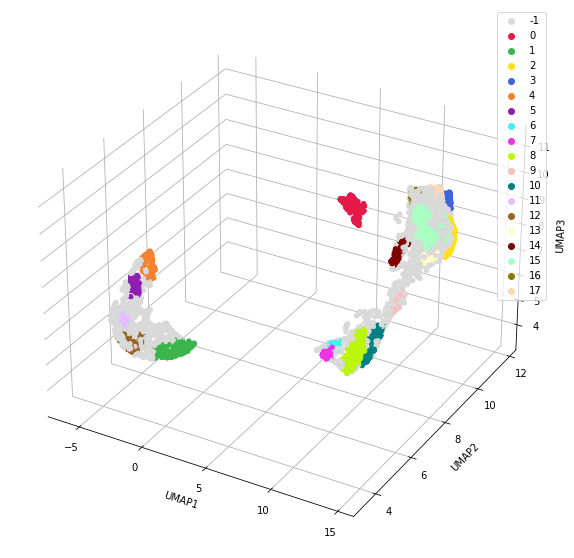

In [17]:
hdb_colors = ['#d9d9d9'] + distinct_colors_22

umap_3Dplot(x=df['UMAP1'],              # xaxis coordinates
            y=df['UMAP2'],              # yaxis coordinates
            z=df['UMAP3'],              # zaxis coordinates
            scat_labels=hdb_labels,     # labels (if available)
            mycolors=hdb_colors,        #  sns.Palette color scheme name or list of colors
            outname=None,               # filename (with path) where figure will be saved. Default: None -> figure not saved
            showlegend=True)            # show legend if True else no legend

### Original labels

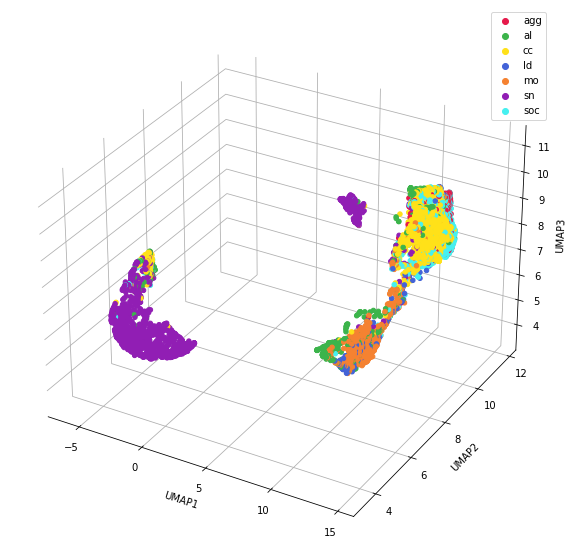

In [18]:
umap_3Dplot(x=df['UMAP1'],              # xaxis coordinates
            y=df['UMAP2'],              # yaxis coordinates
            z=df['UMAP3'],              # zaxis coordinates
            scat_labels=labels,         # labels (if available)
            mycolors=distinct_colors_22,#  sns.Palette color scheme name or list of colors
            outname=None,               # filename (with path) where figure will be saved. Default: None -> figure not saved
            showlegend=True)            # show legend if True else no legend

## Example spectrograms for each HDBSCAN cluster

In [21]:
DISPLAY_COL = 'spectrograms' # column name of spectrogram to display (denoised_spectrograms, spectrograms...)

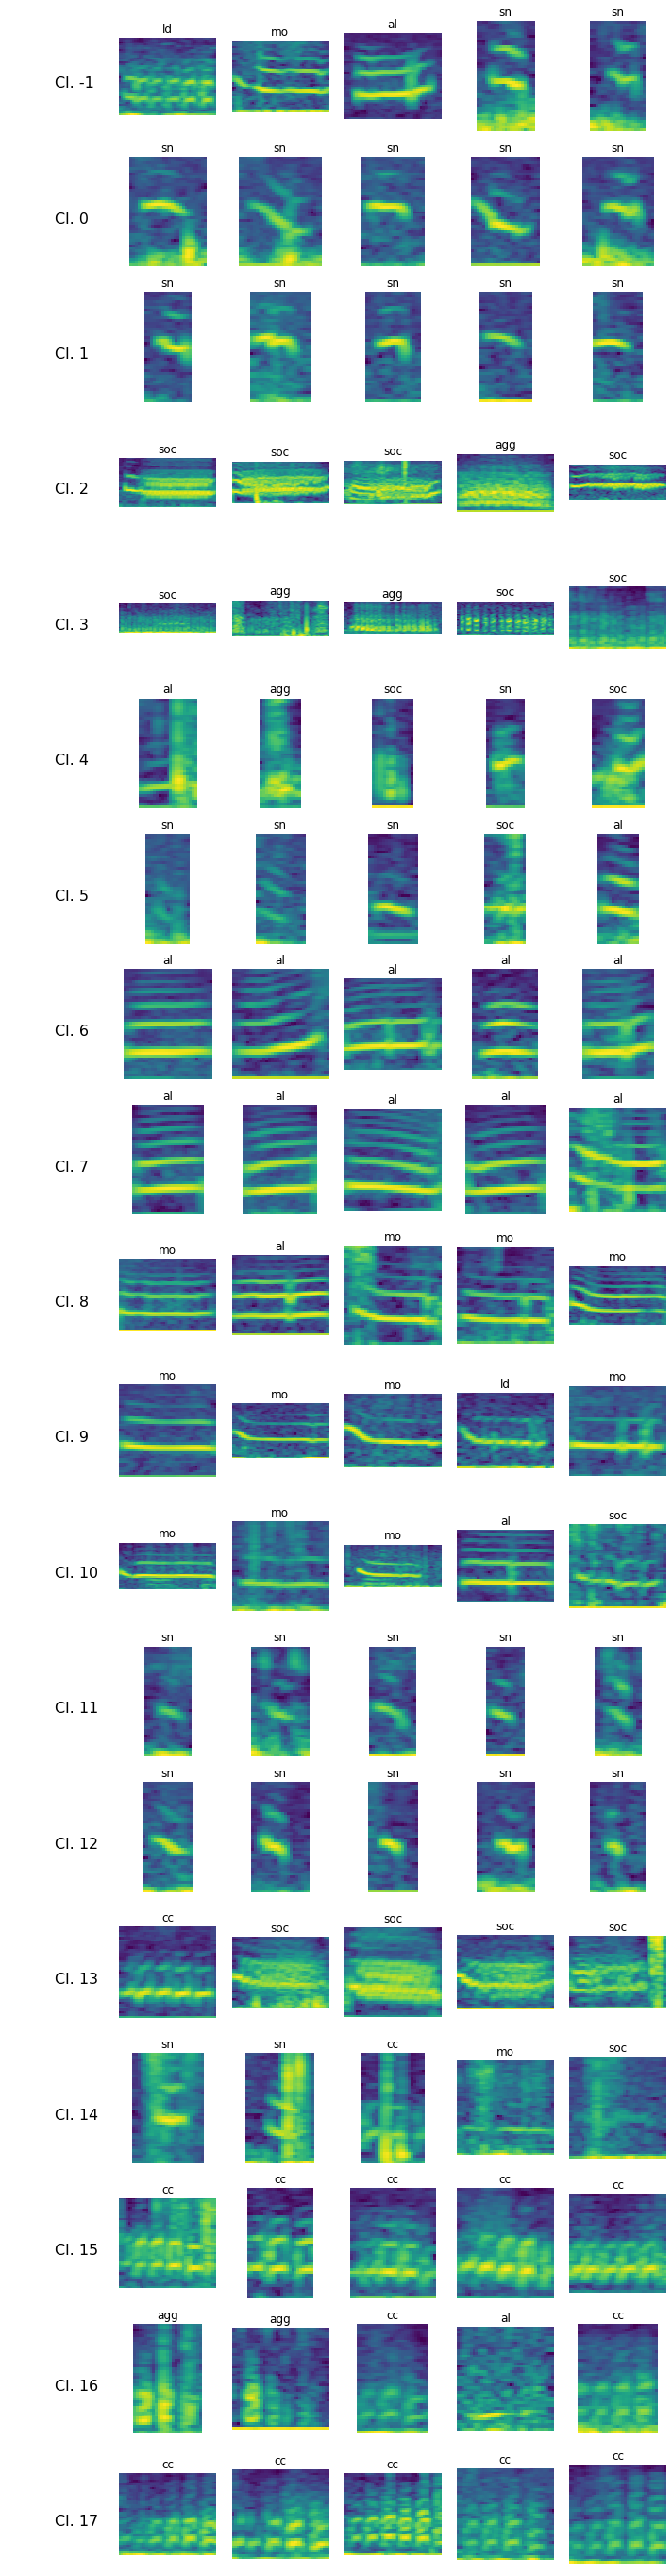

In [26]:
n_specs=5
clusters = sorted(list(set(hdb_labels)))

plt.figure(figsize=(n_specs*2, len(clusters)*2))

k=1
specs = {}

for cluster in clusters:
    example = df[df['HDBSCAN']==cluster].sample(n = n_specs, random_state=2204)
    specs = example[DISPLAY_COL].values
    labels = example[LABEL_COL].values
    i=0 
    
    plt.subplot(len(clusters), n_specs+1, k)
    k+=1    
    plt.axis('off')
    plt.text(0.5,0.4, 'Cl. '+str(cluster), fontsize=16)
    
    
    
    for spec, label in zip(specs, labels):
        plt.subplot(len(clusters), n_specs+1, k)
        plt.imshow(spec, interpolation='nearest', aspect='equal', origin='lower')
        plt.axis('off')
        title = str(label)
        plt.title(title)
        k += 1

plt.tight_layout()

## Analyze cluster content

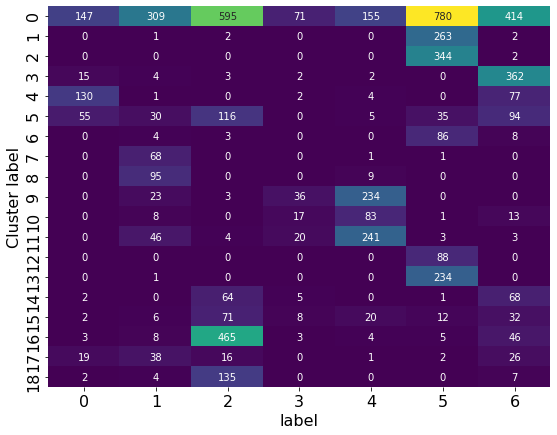

In [61]:
analyze_by = LABEL_COL       # Column name of variable by which to analyze cluster content. 
                             # Select any variable in DF

cluster_labels = hdb_labels  # Variable of cluster labels


cluster_labeltypes = sorted(list(set(cluster_labels)))
by_types = sorted(list(set(df[analyze_by])))
stats_tab = np.zeros((len(cluster_labeltypes), len(by_types)))

for i,clusterlabel in enumerate(cluster_labeltypes):
    label_df = df.loc[cluster_labels==clusterlabel]
    for j, by_type in enumerate(by_types):
        stats_tab[i,j] = sum(label_df[analyze_by]==by_type)

# absolute vals
plt.figure(figsize=(int(len(cluster_labeltypes)/2), int(len(by_types))))
ax = sns.heatmap(stats_tab, annot=True, cmap='viridis', fmt='.0f', cbar=False)
ax.set_xlabel(analyze_by, fontsize=16)
ax.set_ylabel("Cluster label", fontsize=16) 
ax.tick_params(labelsize=16)

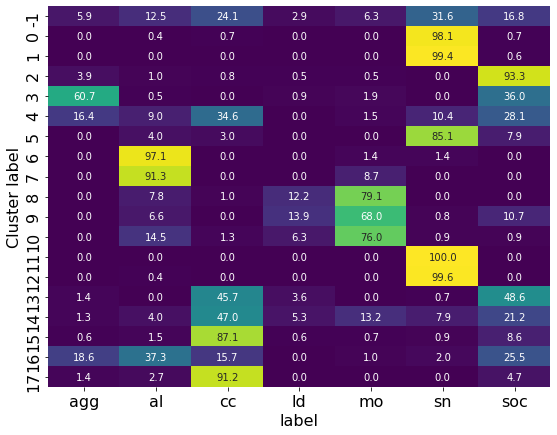

In [62]:
# rowsums
stats_tab_norm = np.zeros((stats_tab.shape))
rowsums = np.sum(stats_tab, axis=1)
for i in range(stats_tab.shape[0]):
    stats_tab_norm[i,:] = stats_tab[i,:]/rowsums[i]
    
stats_tab = pd.DataFrame(stats_tab, index=cluster_labeltypes, columns=by_types)
stats_tab_norm = pd.DataFrame(stats_tab_norm, index=cluster_labeltypes, columns=by_types) * 100

plt.figure(figsize=(int(len(cluster_labeltypes)/2), int(len(by_types))))
ax = sns.heatmap(stats_tab_norm, annot=True, cmap='viridis', fmt='.1f', cbar=False)
ax.set_xlabel(analyze_by, fontsize=16)
ax.set_ylabel("Cluster label", fontsize=16) 
ax.tick_params(labelsize=16)